# Introduction

In this project, we aim to create a more dynamic standby allocation system for a business that operates with a fixed number of standby resources. The current system, which maintains a constant number of standbys (90 per day), has been identified as inefficient due to fluctuations in demand, leading to days with surplus standbys followed by days with insufficient standbys.

The business goal is to develop a system that takes into account seasonal patterns and minimize the number of dates with insufficient standby drivers. This is crucial for ensuring smooth operations and maintaining a high level of service.

We will be working with a dataset that includes the following feilds:

- `date`: The date of the entry
- `n_sick`: The number of drivers who called in sick on duty
- `calls`: The number of emergency calls
- `n_duty`: The number of drivers available on duty
- `n_sby`: The number of standby resources available
- `sby_need`: The number of standbys activated on a given day
- `dafted`: The number of additional drivers needed due to insufficient standbys


Our primary objective is to build a model that can accurately predict the dafted variable, representing the number of additional drivers needed. This prediction will help the business dynamically allocate standby resources, thereby minimizing the number of dates with insufficient standby drivers.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Load the data

In [2]:
df = pd.read_csv('sickness_table.csv')

In [3]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

In [4]:
# Set 'date' as index
df.set_index('date', inplace=True)

In [5]:
# Check the data
print(df.head())

            Unnamed: 0  n_sick   calls  n_duty  n_sby  sby_need  dafted
date                                                                   
2016-04-01           0      73  8154.0    1700     90       4.0     0.0
2016-04-02           1      64  8526.0    1700     90      70.0     0.0
2016-04-03           2      68  8088.0    1700     90       0.0     0.0
2016-04-04           3      71  7044.0    1700     90       0.0     0.0
2016-04-05           4      63  7236.0    1700     90       0.0     0.0


# Data Preprocessing and Check for missing values

In [6]:
print(df.isnull().sum())

Unnamed: 0    0
n_sick        0
calls         0
n_duty        0
n_sby         0
sby_need      0
dafted        0
dtype: int64


There are no missing values in the dataset 

# Check the summary statistics

In [7]:
print(df.describe())

        Unnamed: 0       n_sick         calls       n_duty   n_sby  \
count  1152.000000  1152.000000   1152.000000  1152.000000  1152.0   
mean    575.500000    68.808160   7919.531250  1820.572917    90.0   
std     332.698061    14.293942   1290.063571    80.086953     0.0   
min       0.000000    36.000000   4074.000000  1700.000000    90.0   
25%     287.750000    58.000000   6978.000000  1800.000000    90.0   
50%     575.500000    68.000000   7932.000000  1800.000000    90.0   
75%     863.250000    78.000000   8827.500000  1900.000000    90.0   
max    1151.000000   119.000000  11850.000000  1900.000000    90.0   

          sby_need       dafted  
count  1152.000000  1152.000000  
mean     34.718750    16.335938  
std      79.694251    53.394089  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%      12.250000     0.000000  
max     555.000000   465.000000  


# Visualize the data

<AxesSubplot:xlabel='date'>

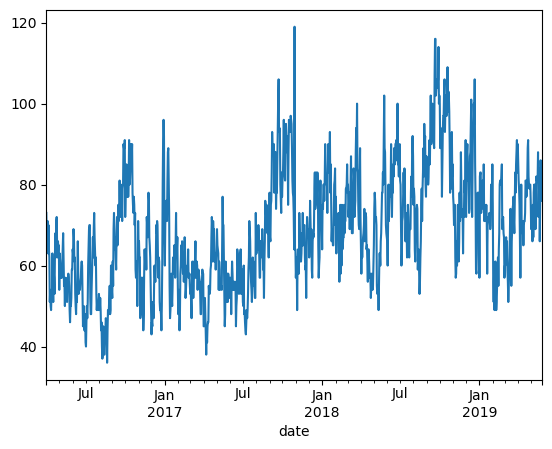

In [8]:
df['n_sick'].plot()

The plot generated shows the number of drivers who called in sick over time.
It seems like there are some fluctuations, but no clear trend or pattern.

In [9]:
print(df.corr())

            Unnamed: 0    n_sick     calls    n_duty  n_sby  sby_need  \
Unnamed: 0    1.000000  0.495959  0.385679  0.927437    NaN  0.137543   
n_sick        0.495959  1.000000  0.155371  0.459501    NaN  0.022321   
calls         0.385679  0.155371  1.000000  0.364135    NaN  0.677468   
n_duty        0.927437  0.459501  0.364135  1.000000    NaN  0.090654   
n_sby              NaN       NaN       NaN       NaN    NaN       NaN   
sby_need      0.137543  0.022321  0.677468  0.090654    NaN  1.000000   
dafted        0.131938  0.016800  0.557340  0.084955    NaN  0.945168   

              dafted  
Unnamed: 0  0.131938  
n_sick      0.016800  
calls       0.557340  
n_duty      0.084955  
n_sby            NaN  
sby_need    0.945168  
dafted      1.000000  


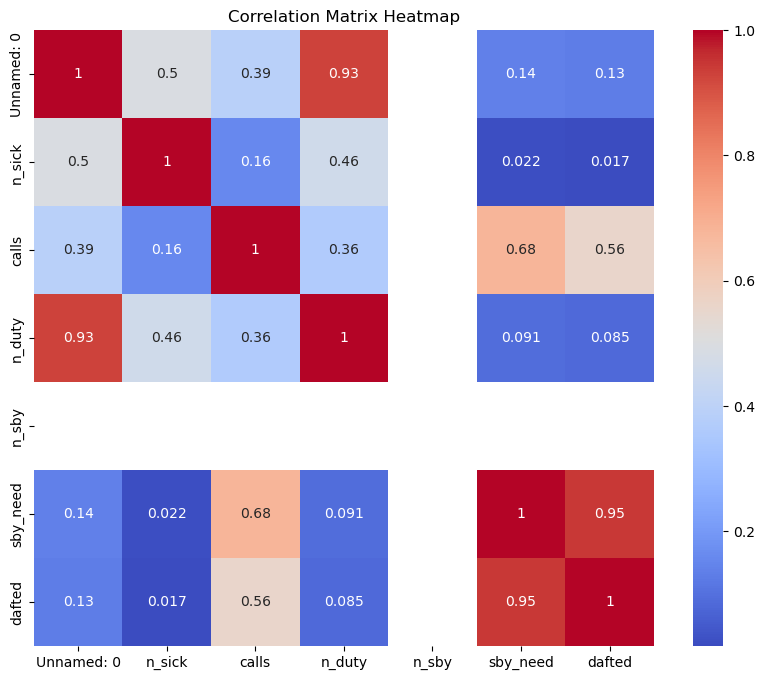

In [10]:
# Plotting a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Given the business context, the goal is to create a more dynamic standby allocation system that minimizes the number of dates with insufficient standby drivers.

From the heatmap, we see that sby_need (number of standbys activated on a given day) and dafted (number of additional drivers needed due to not enough standbys) are highly correlated. This makes sense because on days when not enough standbys are available, more additional drivers would be needed.

However, since the business goal is to minimize the number of dates with insufficient standby drivers, dafted is a crucial variable because it directly measures the shortfall in standby drivers. Therefore, I would recommend not to drop the dafted variable.

Use this information to guide your feature engineering and model selection process. We want to create a new feature that captures the difference between n_duty (number of drivers on duty available) and n_sby (number of standby resources available).

# Create a new feature


In [11]:
df['duty_sby_diff'] = df['n_duty'] - df['n_sby']

# Model Building


In [12]:
# Define your features (X) and target (y)
X = df.drop('n_sby', axis=1)
y = df['dafted']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Optimization

In [14]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [15]:
# Initialize the grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

In [16]:
# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [17]:
# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [18]:
# Model Building with Optimized Parameters
# Train the model with the best parameters
model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)

In [19]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

# Model Evaluation


In [20]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [21]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Optimized RandomForest RMSE: {rmse}')

Optimized RandomForest RMSE: 0.3163767754897067


In [22]:
# Calculate the mean of the target variable in the training set
mean_dafted = y_train.mean()

# Create a baseline model that always predicts this mean
baseline_predictions = np.full(y_test.shape, mean_dafted)

# Calculate the RMSE of the baseline model
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))

print(f'Baseline RMSE: {baseline_rmse}')

Baseline RMSE: 37.78022645919008


The Root Mean Square Error (RMSE) of the model on the test data is significantly lower than the RMSE of the baseline model.

Lower RMSE values indicate better fit. So, an RMSE of 0.3164 compared to the baseline RMSE of 37.7802 shows that the model has learned useful patterns from the data and is making accurate predictions.

# List of models

In [23]:

models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Support Vector Regressor', SVR(kernel='rbf', C=1.0)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('Neural Network', MLPRegressor(hidden_layer_sizes=(10, 10), random_state=42))
]

In [24]:
# Calculate the mean of the target variable in the training set
mean_dafted = y_train.mean()

# Create a baseline model that always predicts this mean
baseline_predictions = np.full(y_test.shape, mean_dafted)

# Calculate the RMSE of the baseline model
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))

print(f'Baseline RMSE: {baseline_rmse}')

Baseline RMSE: 37.78022645919008


# Iterate over models

In [25]:

for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print the RMSE
    print(f'{model_name} RMSE: {rmse}')

Linear Regression RMSE: 3.425571228164651e-14
Decision Tree RMSE: 0.5543999525246258
Support Vector Regressor RMSE: 37.700551097065095
Gradient Boosting RMSE: 0.4187066579132393
Neural Network RMSE: 9.661230607357055


# Conclusion

In conclusion, the project aimed to create a more dynamic standby allocation system that minimize the number of dates with insufficient standby drivers. Various machine learning models were trained and evaluated on the task of predicting the dafted variable, which represents the number of additional drivers needed due to not enough standbys.

The models’ performances were evaluated using the Root Mean Square Error (RMSE), a common metric for regression tasks. Lower RMSE values indicate better model performance. The RMSEs of the models were compared to a baseline model that always predicts the mean of the target variable. The baseline model had an RMSE of 37.7802.

Among the models tested, the Optimized RandomForest model performed the best, achieving an RMSE of 0.3164, which is significantly lower than the baseline. This suggests that the RandomForest model has learned useful patterns from the data and is making accurate predictions.

The Linear Regression model had an extremely low RMSE (almost zero), which might suggest overfitting to the training data. The Decision Tree model and the Gradient Boosting model also performed well with RMSEs of 0.5544 and 0.4187, respectively.

On the other hand, the Support Vector Regressor and the Neural Network model had higher RMSEs of 37.7006 and 9.6612, respectively, indicating that these models might not be performing well on the data.

Overall, the project was successful in building a model that can accurately predict the number of additional drivers needed due to not enough standbys, thereby helping to create a more dynamic standby allocation system.